In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import mne
import plotly.express as px
import seaborn as sns
import pandas as pd
import xmltodict
import math

In [2]:
DEFAULT_CHANNEL_NAMES = ['Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',       
                         'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1',       
                         'FCz', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz',       
                         'C2', 'C4', 'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2',       
                         'CP4', 'CP6', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 
                         'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'F9', 
                         'F10', 'A1', 'A2']

In [3]:
def mneRawFromHdf5(filepath, have_ch_names, sfreq, first_secs_to_trunc, ref_ch=None):
    hf = h5py.File(filepath, 'r')
    #print(hf.keys())
    data_array = np.divide(np.array(hf.get('RawData/Samples'))[first_secs_to_trunc*sfreq:].T,1e6)
    if have_ch_names:
        acq_task_desc = hf.get('RawData/AcquisitionTaskDescription')
        #print(xmltodict.parse(np.array(acq_task_desc)[0])['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties'])
        ch_num_name_lookup = {}
        ch_props = xmltodict.parse(np.array(acq_task_desc)[0])['AcquisitionTaskDescription']['ChannelProperties']['ChannelProperties']
        for prop in ch_props:
            #print(prop['LogicalChannelNumber']+', '+prop['ChannelName'])
            if prop['ChannelName']:
                ch_num_name_lookup[prop['LogicalChannelNumber']] = prop['ChannelName']
            else: 
                #print(prop['LogicalChannelNumber'])
                ch_num_name_lookup[prop['LogicalChannelNumber']] = DEFAULT_CHANNEL_NAMES[int(prop['LogicalChannelNumber'])-1]
        
        ch_names = [ch_num_name_lookup[num] for num in ch_num_name_lookup.keys()]
    else:
        ch_names = ['Channel' + str(i + 1) for i in range(data_array.shape[0])]
    
    ch_types = ['eeg' for i in range(data_array.shape[0])]
    eeg_info = mne.create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq)
    raw_eeg = mne.io.RawArray(data_array, eeg_info)

    if ref_ch:
        raw_eeg.set_eeg_reference(ref_channels=ref_ch)


    return raw_eeg

In [4]:
def plotMNEData(mne_data, domain, scaling, plt_x_range, title, x_label, y_label, plt_method, 
                channels=[],show_param_ch=False,save_plt_to='', show_plt=False):
    if domain == 'time':
        mne_data_df = mne_data.to_data_frame(scalings=scaling)
    elif domain == 'freq':
        mne_data_df = mne_data.to_data_frame(copy=True)
        # Scaling with 1e12 to micro-volt^2/Hz
        for col in mne_data_df.drop(['freq'],axis=1):
            mne_data_df[col] = mne_data_df[col]*1e12
    
    if show_param_ch:
        ch_not_to_show = [ch for ch in mne_data.ch_names if ch not in channels]
    else:
        ch_not_to_show = channels
    mne_data_df = mne_data_df[(mne_data_df[domain]>plt_x_range[0]) & (mne_data_df[domain]<plt_x_range[1])]
    if plt_method == 'plotly':
        fig = px.line(mne_data_df, x=domain, y=mne_data_df.drop(columns=[domain]+ch_not_to_show).columns,
                      title=title,labels={domain:x_label, 'value':y_label})
        
        if save_plt_to:
            fig.write_html(save_plt_to)
        if show_plt:
            fig.show()
    
    elif plt_method == 'pyplot':
        plt.figure(figsize=(16, 15))
        #print(mne_data_df.drop(columns=[domain]+ch_not_to_show).head())
        plt.plot(mne_data_df[domain], mne_data_df.drop(columns=[domain]+ch_not_to_show))
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend(mne_data_df.drop(columns=[domain]+ch_not_to_show).columns, loc="best", prop={'size': 8})

        if save_plt_to:
            plt.savefig(save_plt_to)
        if show_plt:
            plt.show()
        


In [5]:
def plotMNEArrSubplots(mne_eeg_arr,scaling,title,channel_names,time_range = (0,0),figure_size = (10,18),sfreq = 512):
    #plot the eeg data in four subplots(divide data into four parts)
    #display partial time only works for dataframe data

    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    if time_range == (0,0):
        selected_time_data = eeg_df
    else:
        start,end = time_range
        selected_time_data = eeg_df[(eeg_df['time']>=start) & (eeg_df['time']<=end)]
    x = selected_time_data['time']
    y = selected_time_data.iloc[:,1:]

    #plt.figure(figsize=fig_size)
    fig, axs = plt.subplots(4,figsize= figure_size)
    fig.suptitle(title, y = 0.99)
    num_channels  = len(channel_names)
    NUM_COLORS = math.ceil(num_channels/4)
    num_remaining_channels = num_channels - (3*NUM_COLORS)
    sub_titles = ['First {} Channels'.format(NUM_COLORS),'Second {} Channels'.format(NUM_COLORS),'Third {} Channels'.format(NUM_COLORS),\
                   'Remaining {} Channels'.format(num_remaining_channels)]
    #cm = plt.get_cmap('gist_rainbow')
    colors = plt.cm.Spectral(np.linspace(0,1,NUM_COLORS))
    for i in range(4):
        axs[i].set_prop_cycle(color=colors)
        axs[i].plot(x,y.iloc[:,i*NUM_COLORS:(i+1)*NUM_COLORS])
        axs[i].set_title(sub_titles[i])
        axs[i].legend(channel_names[i*NUM_COLORS:(i+1)*NUM_COLORS],loc = 'upper right')
        axs[i].set_xlabel('Time [s]')
        axs[i].set_ylabel('Microvolts [mV]')
    fig.tight_layout()
    plt.show()

In [6]:
re_ref_eo_eeg = mneRawFromHdf5('EEG_data/eye open ryan2024.03.22_15.46.41.hdf5', True, 512, 170, ['A1','A2'])
re_ref_ec_eeg = mneRawFromHdf5('EEG_data/eye closed ryan2024.03.22_15.26.54.hdf5', True, 512, 170, ['A1','A2'])

#re_ref_eo_eeg = mneRawFromHdf5('EEG_data/eye open2024.04.15_11.11.59.hdf5', True, 512, 100, ['A1','A2'])
#re_ref_ec_eeg = mneRawFromHdf5('EEG_data/eye closed2024.04.15_11.05.18.hdf5', True, 512, 100, ['A1','A2'])

Creating RawArray with float64 data, n_channels=64, n_times=66564
    Range : 0 ... 66563 =      0.000 ...   130.006 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.
Creating RawArray with float64 data, n_channels=64, n_times=66575
    Range : 0 ... 66574 =      0.000 ...   130.027 secs
Ready.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


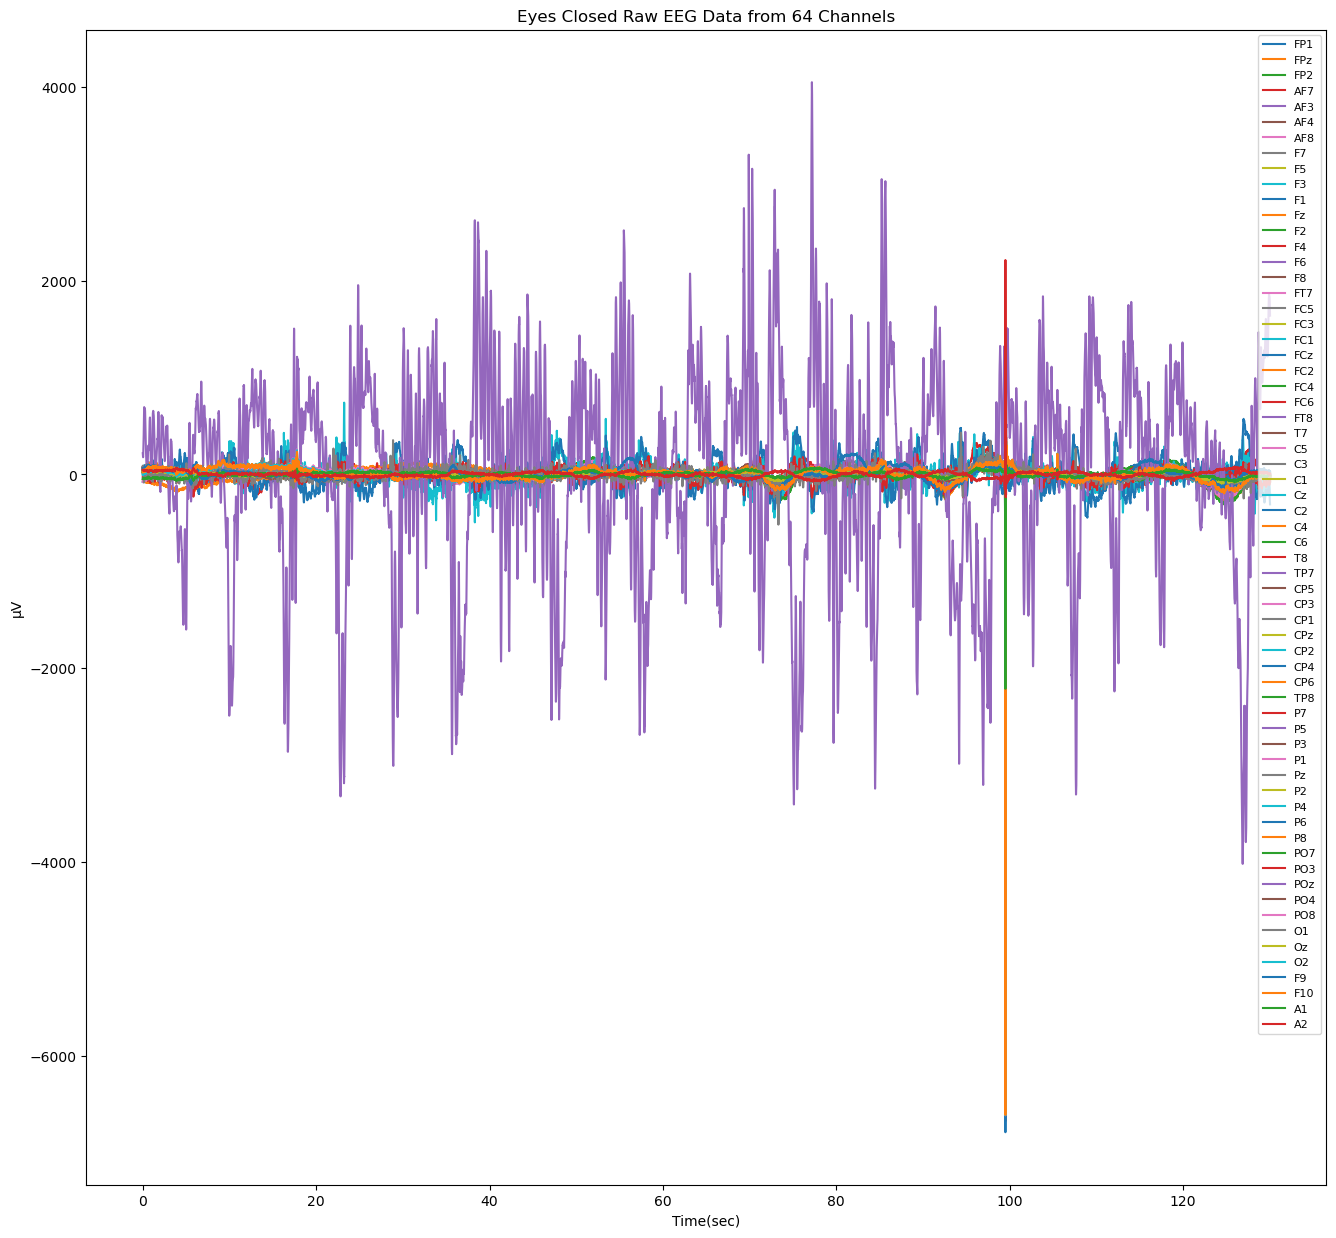

In [7]:
plotMNEData(mne_data=re_ref_ec_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Closed Raw EEG Data from %d Channels'%(len(re_ref_ec_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='ec_raw_eeg.png', show_plt=True, show_param_ch=False,)
            #channels=['F6','F7','F8'])

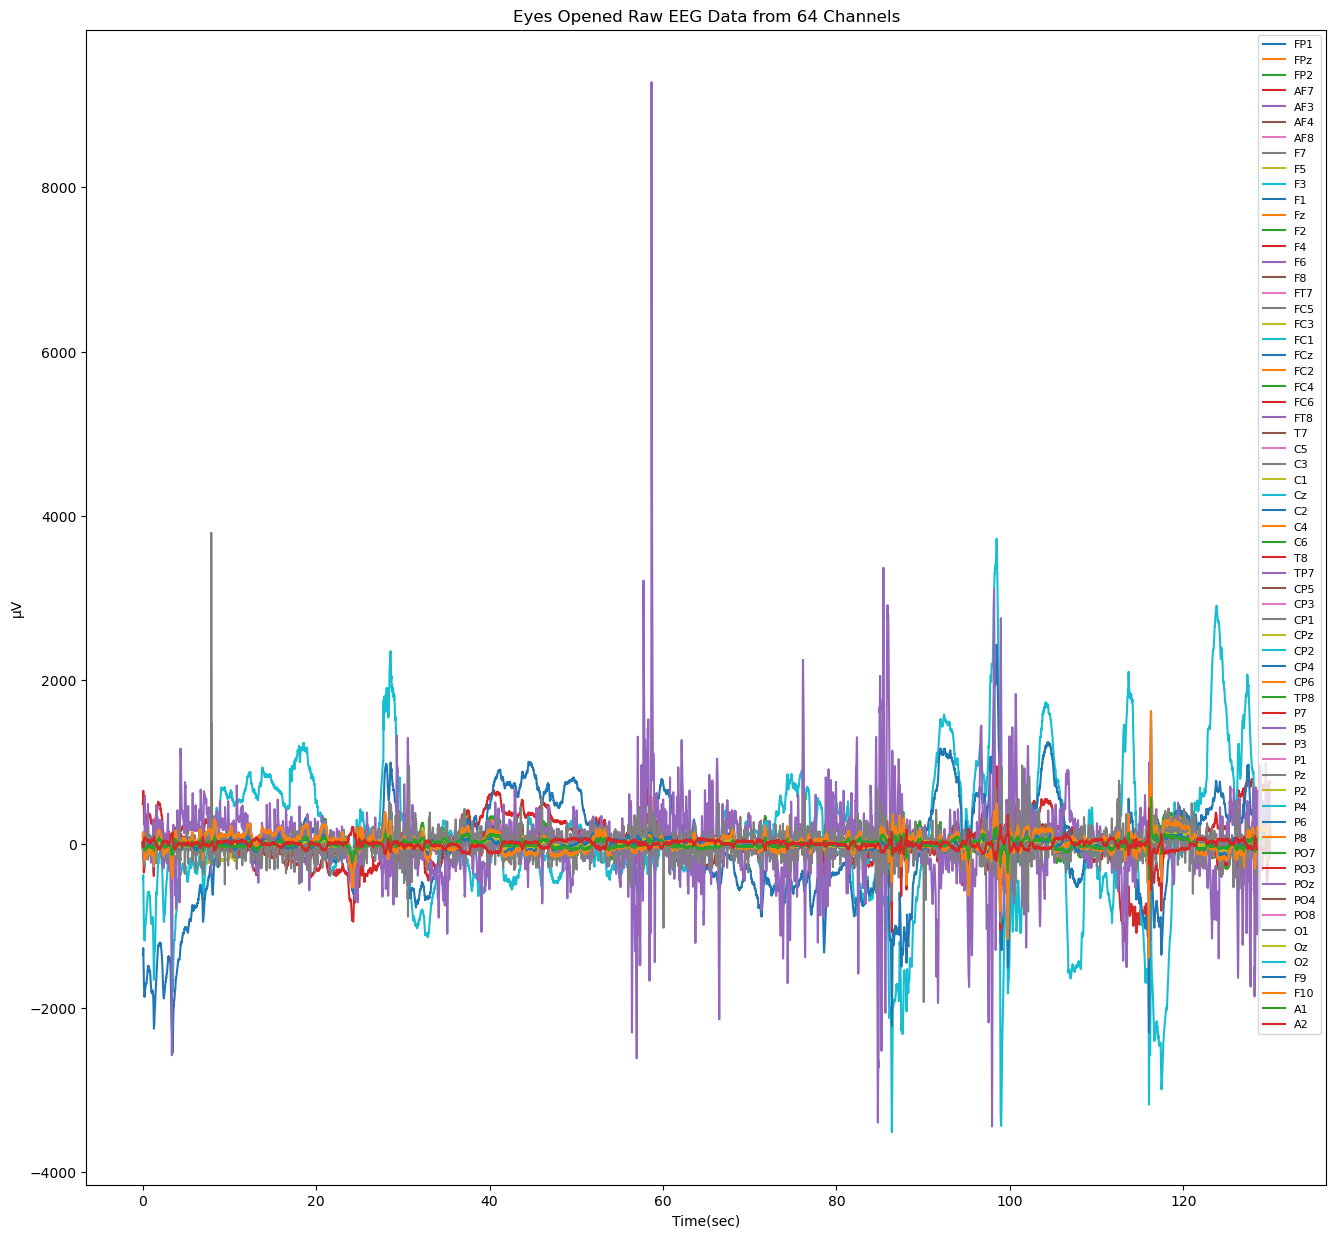

In [8]:
plotMNEData(mne_data=re_ref_eo_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Opened Raw EEG Data from %d Channels'%(len(re_ref_eo_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot', 
            save_plt_to='eo_raw_eeg.png', show_plt=True, show_param_ch=False,)
            #channels=['F6','F7','F8'])

In [7]:
def badChByCutoff(mne_eeg_arr, scaling, cutoff_amplitude, cutoff_ratio):
    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    amp_volts = eeg_df.iloc[:,1:].abs()
    
    exceed_val_counts = amp_volts[amp_volts>=cutoff_amplitude].count()
    exceed_val_counts = exceed_val_counts[exceed_val_counts>0]
    #print(exceed_val_counts)
    
    exceed_val_ratio = (exceed_val_counts/len(eeg_df)).sort_values(ascending = True)
    #print(exceed_val_ratio)
    
    bad_channels = list(exceed_val_ratio[exceed_val_ratio>=cutoff_ratio].index)
    print(bad_channels)
    
    eeg_arr_dropped_bad_ch = mne_eeg_arr.copy().drop_channels(ch_names=bad_channels)
    return eeg_arr_dropped_bad_ch


In [8]:
# For ryan eyes open/close data
eo_eeg_wo_bad_ch = badChByCutoff(re_ref_eo_eeg, 1e6, 500, 0.003)
ec_eeg_wo_bad_ch = badChByCutoff(re_ref_ec_eeg, 1e6, 500, 0.003)

# For eye open/close2024.04.15 data 
#eo_eeg_wo_bad_ch = badChByCutoff(re_ref_eo_eeg, 1e6, 500, 0.03)
#ec_eeg_wo_bad_ch = badChByCutoff(re_ref_ec_eeg, 1e6, 500, 0.03)

['CP2', 'PO8', 'O2', 'F10', 'PO3', 'O1', 'T8', 'POz', 'P6', 'P4']
['POz']


In [9]:
def badChByStd(mne_eeg_arr, scaling, std_tolerance=None):
    eeg_df = mne_eeg_arr.to_data_frame(scalings=scaling)
    sorted_std_ch = eeg_df.iloc[:,1:].std().sort_values(ascending = False)
    
    mean_of_std = sorted_std_ch.mean()
    print('mean value of channel std',mean_of_std)
    std_of_std = sorted_std_ch.std()
    print('std of channel std',std_of_std)
    print(sorted_std_ch[:10])

    if not std_tolerance:
        std_tolerance = std_of_std*0.1
        
    bad_channels = list(sorted_std_ch[sorted_std_ch>=(mean_of_std+3*std_of_std+std_tolerance)].index)
    print(bad_channels)
    
    eeg_arr_dropped_bad_ch = mne_eeg_arr.copy().drop_channels(ch_names=bad_channels)
    return eeg_arr_dropped_bad_ch

In [10]:
eo_eeg_wo_bad_ch = badChByStd(eo_eeg_wo_bad_ch, 1e6)
ec_eeg_wo_bad_ch = badChByStd(ec_eeg_wo_bad_ch, 1e6)

mean value of channel std 66.59719696323243
std of channel std 22.13317346690533
FP2    149.505392
FPz    135.792990
FP1    121.039154
AF8    107.954653
AF7    105.659058
AF4     95.734132
F5      89.532453
AF3     85.199965
F8      77.317133
F7      76.625392
dtype: float64
['FP2', 'FPz']
mean value of channel std 54.43188729851976
std of channel std 24.055696412151534
P6     164.481124
P4     132.206348
T8     104.942900
PO3     89.772648
O2      87.636740
F10     87.473217
PO8     86.924488
FP2     86.495216
FPz     79.436943
FP1     72.667312
dtype: float64
['P6', 'P4']


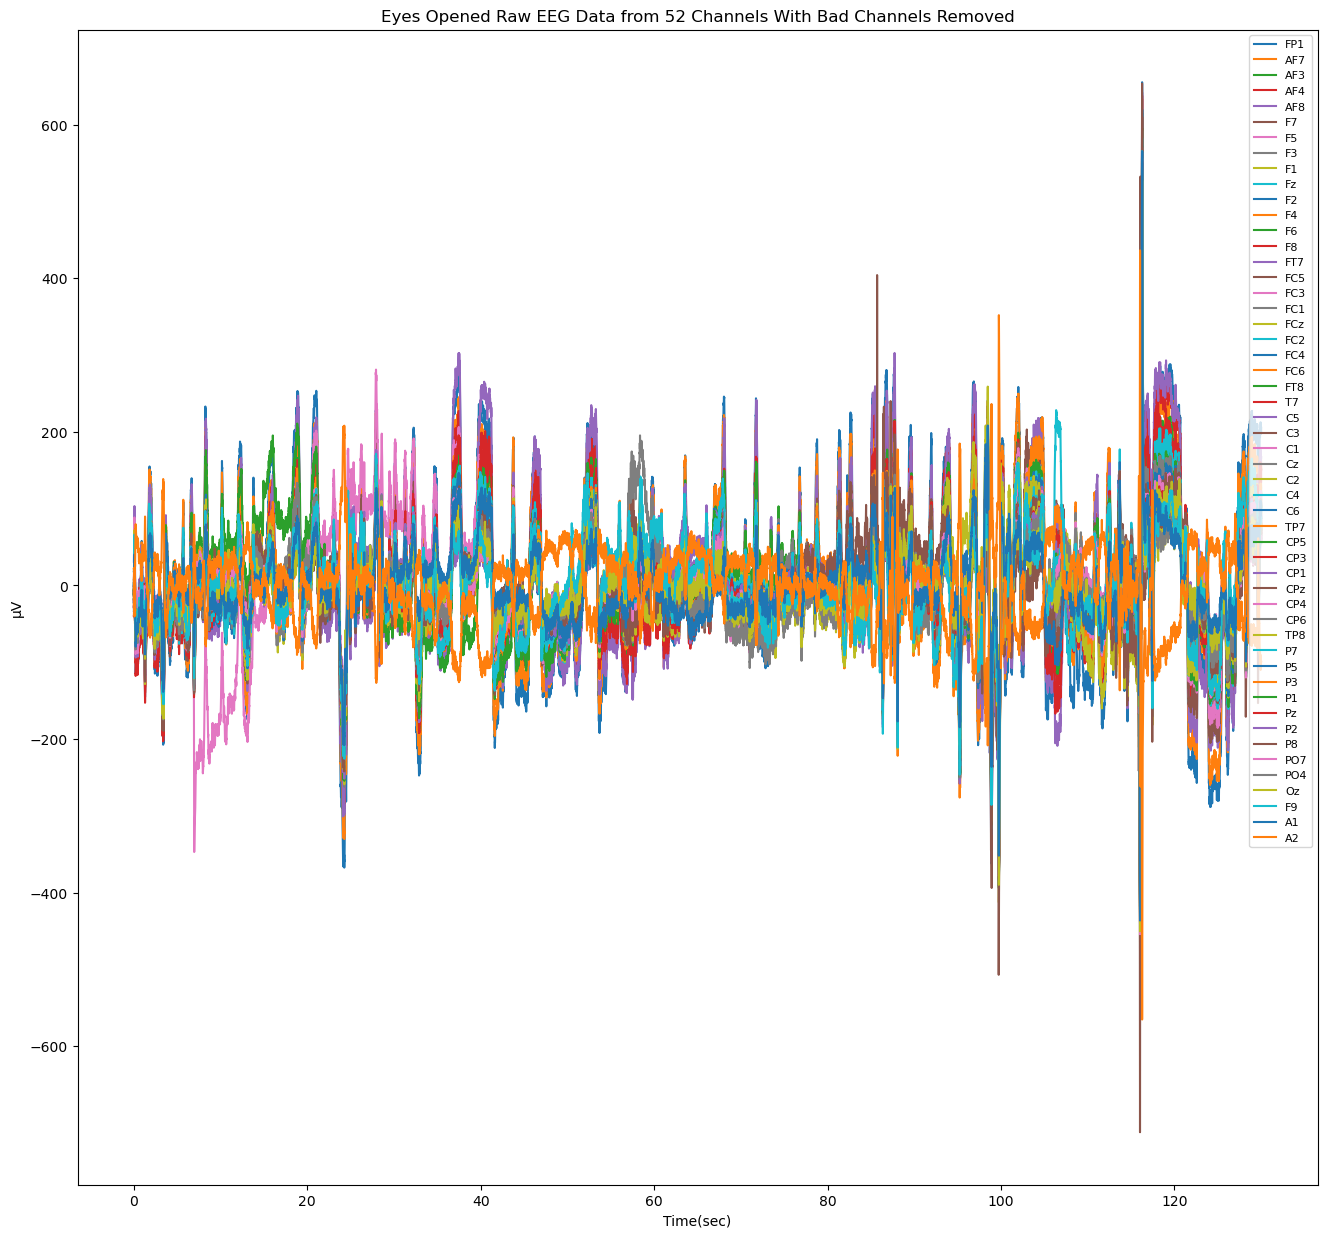

In [25]:
plotMNEData(mne_data=eo_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Opened Raw EEG Data from %d Channels With Bad Channels Removed'%(len(eo_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='eo_eeg_wo_bad_ch.png', show_plt=True, show_param_ch=False,)
            #channels=['F6','F7','F8'])

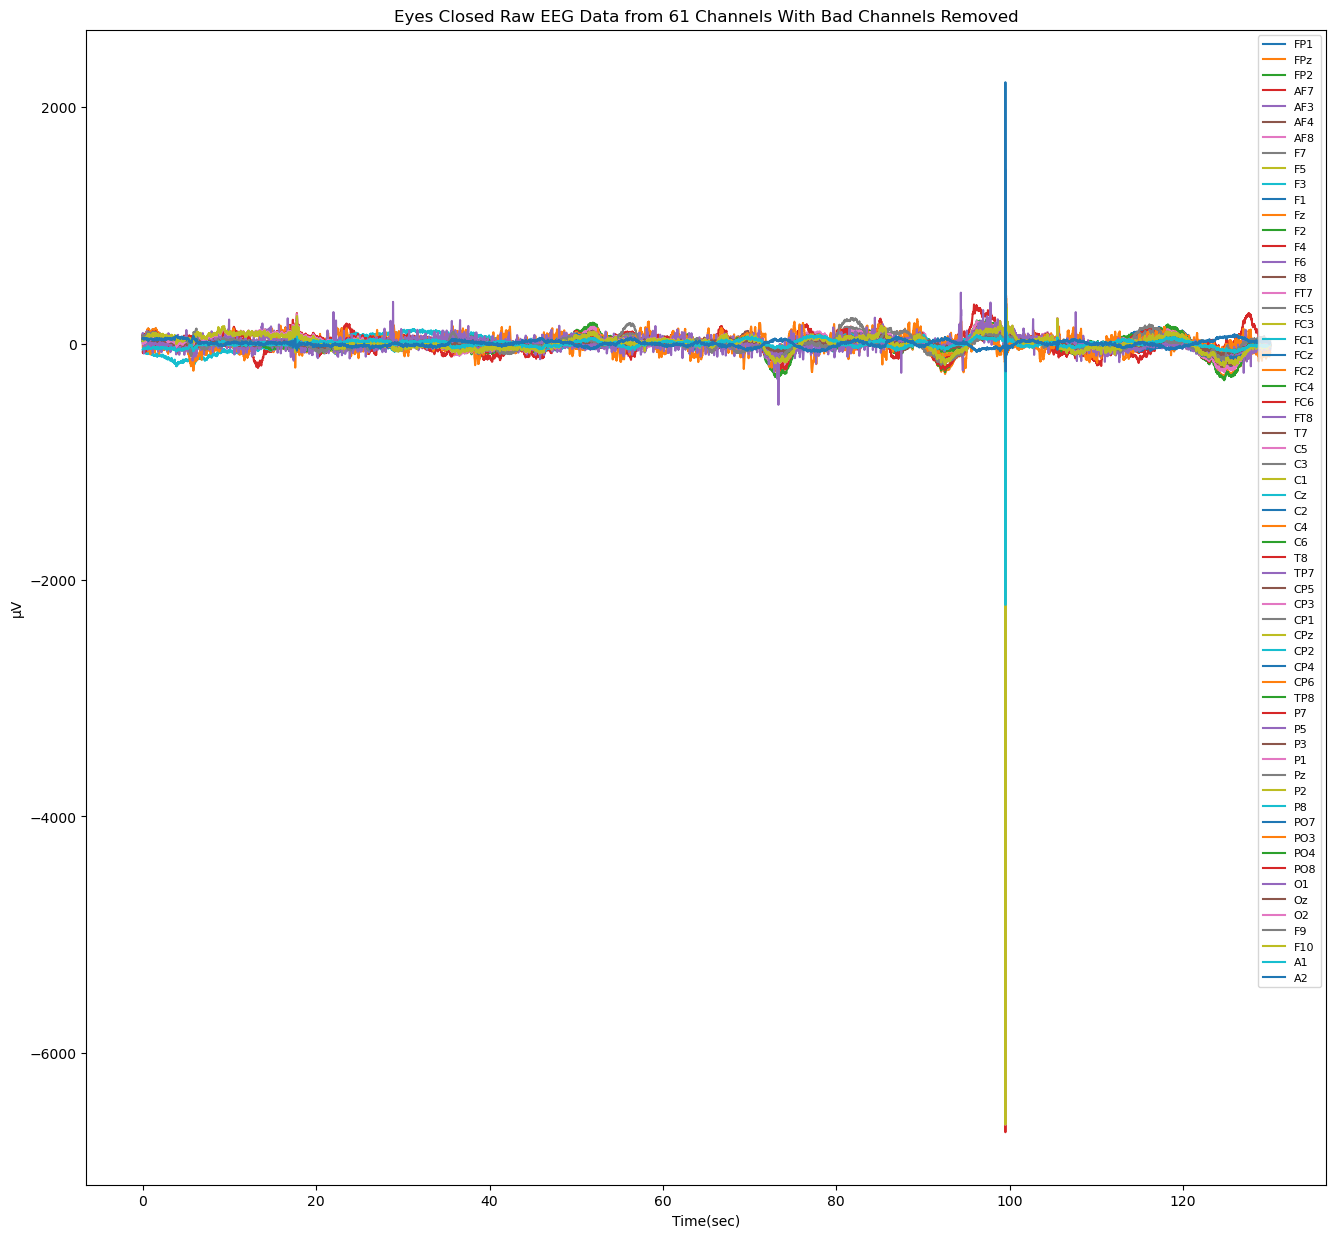

In [26]:
plotMNEData(mne_data=ec_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Closed Raw EEG Data from %d Channels With Bad Channels Removed'%(len(ec_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='ec_eeg_wo_bad_ch.png', show_plt=True, show_param_ch=False,)
            #channels=['F6','F7','F8'])

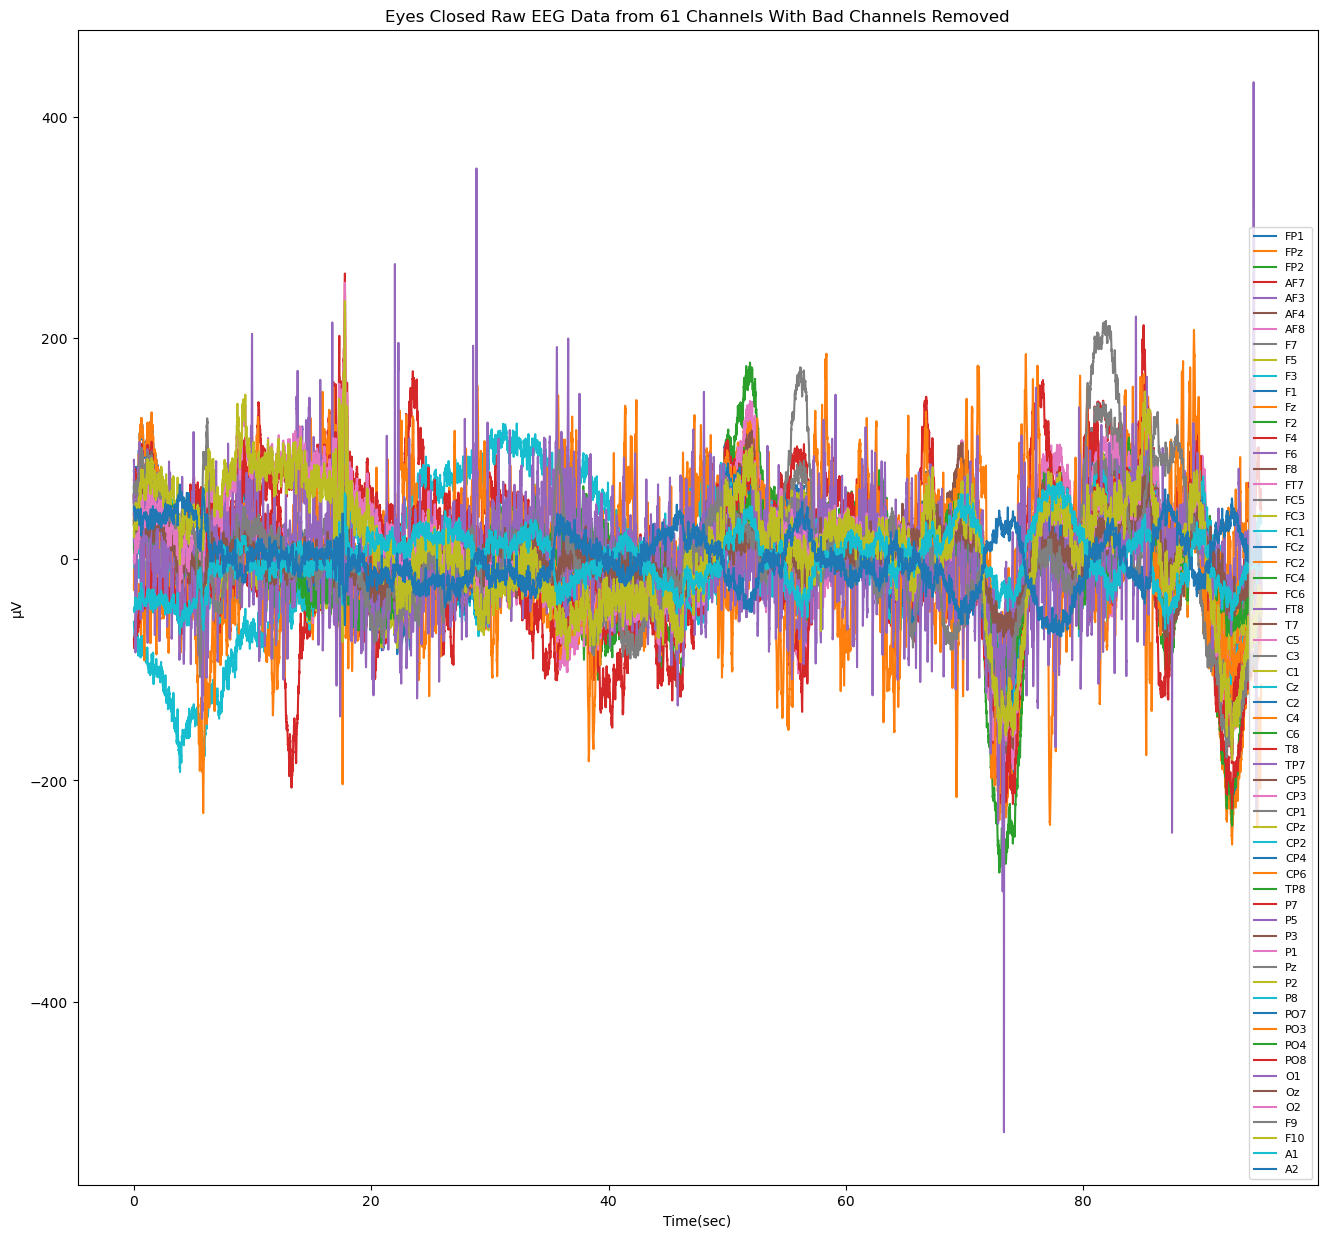

In [27]:
plotMNEData(mne_data=ec_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,95),
            title='Eyes Closed Raw EEG Data from %d Channels With Bad Channels Removed'%(len(ec_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='ec_eeg_wo_bad_ch.png', show_plt=True, show_param_ch=False,)
            #channels=['F6','F7','F8'])

In [11]:
# Band-pass and Notch filters
#For ryan eyes open/close data
low_cut = 1
#For eye open/close2024.04.15 data 
#low_cut = 1
hi_cut  = 30
filtered_eo_eeg = eo_eeg_wo_bad_ch.copy().filter(l_freq=low_cut,h_freq=hi_cut,fir_design='firwin')
filtered_ec_eeg = ec_eeg_wo_bad_ch.copy().filter(l_freq=low_cut,h_freq=hi_cut,fir_design='firwin')
filtered_eo_eeg = filtered_eo_eeg.copy().notch_filter(60, method='fir')
filtered_ec_eeg = filtered_ec_eeg.copy().notch_filter(60, method='fir')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (3.303 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 3

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 3381 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth:

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


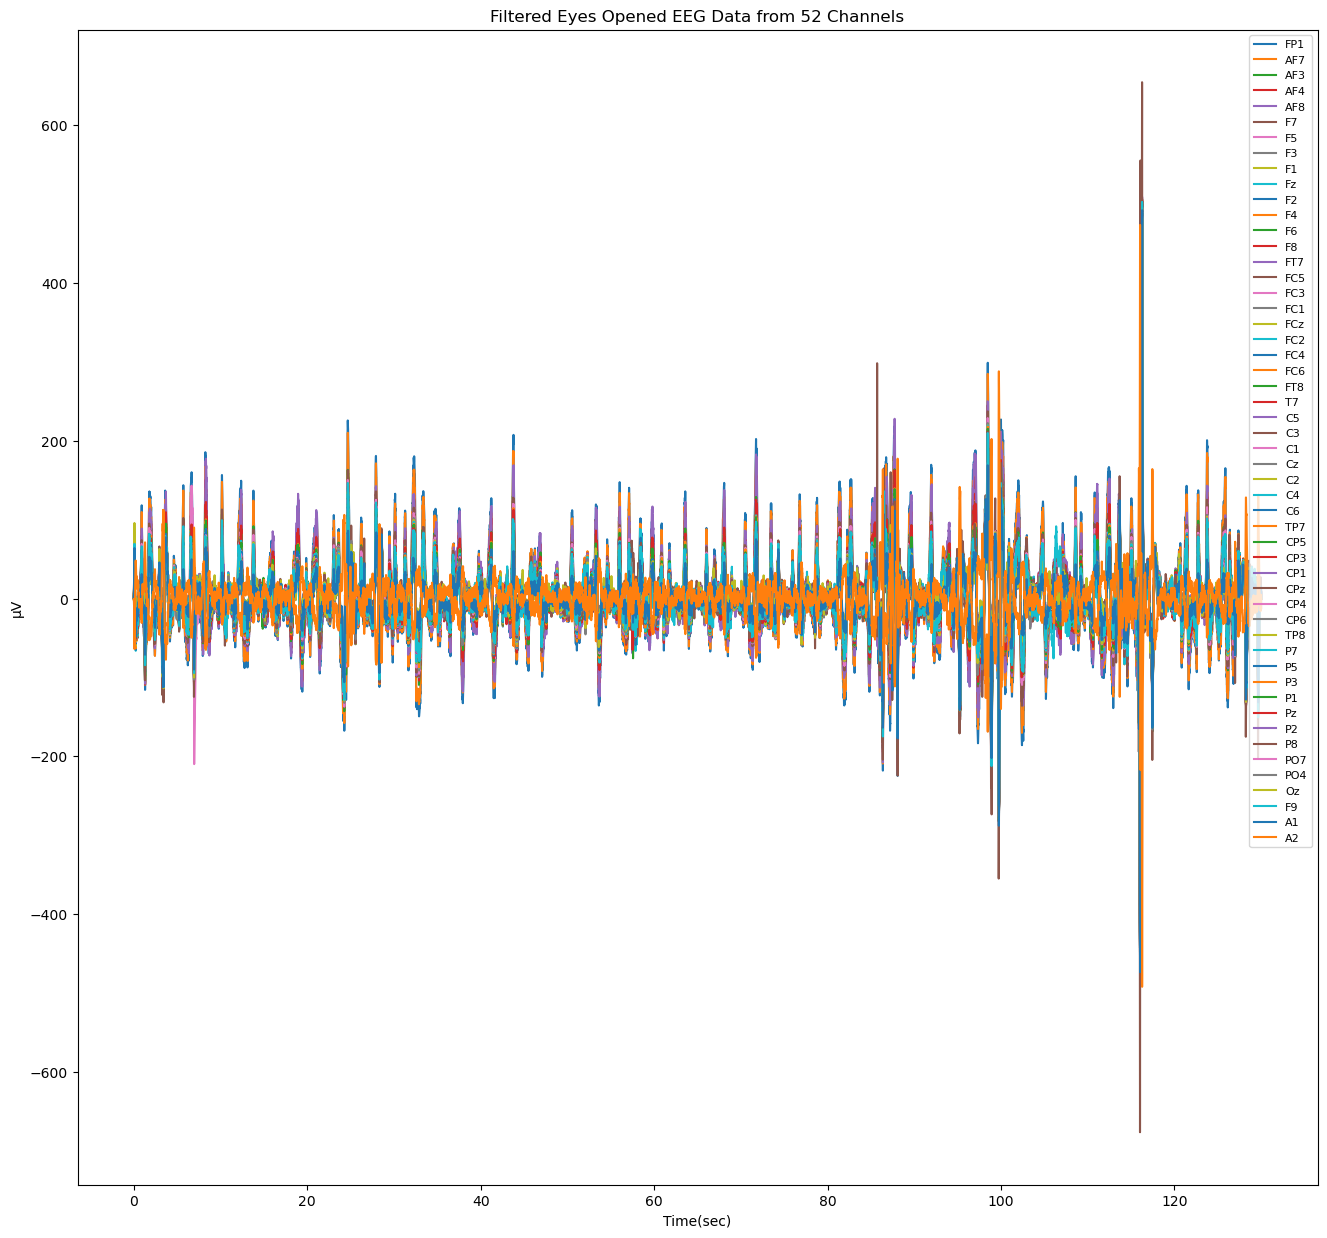

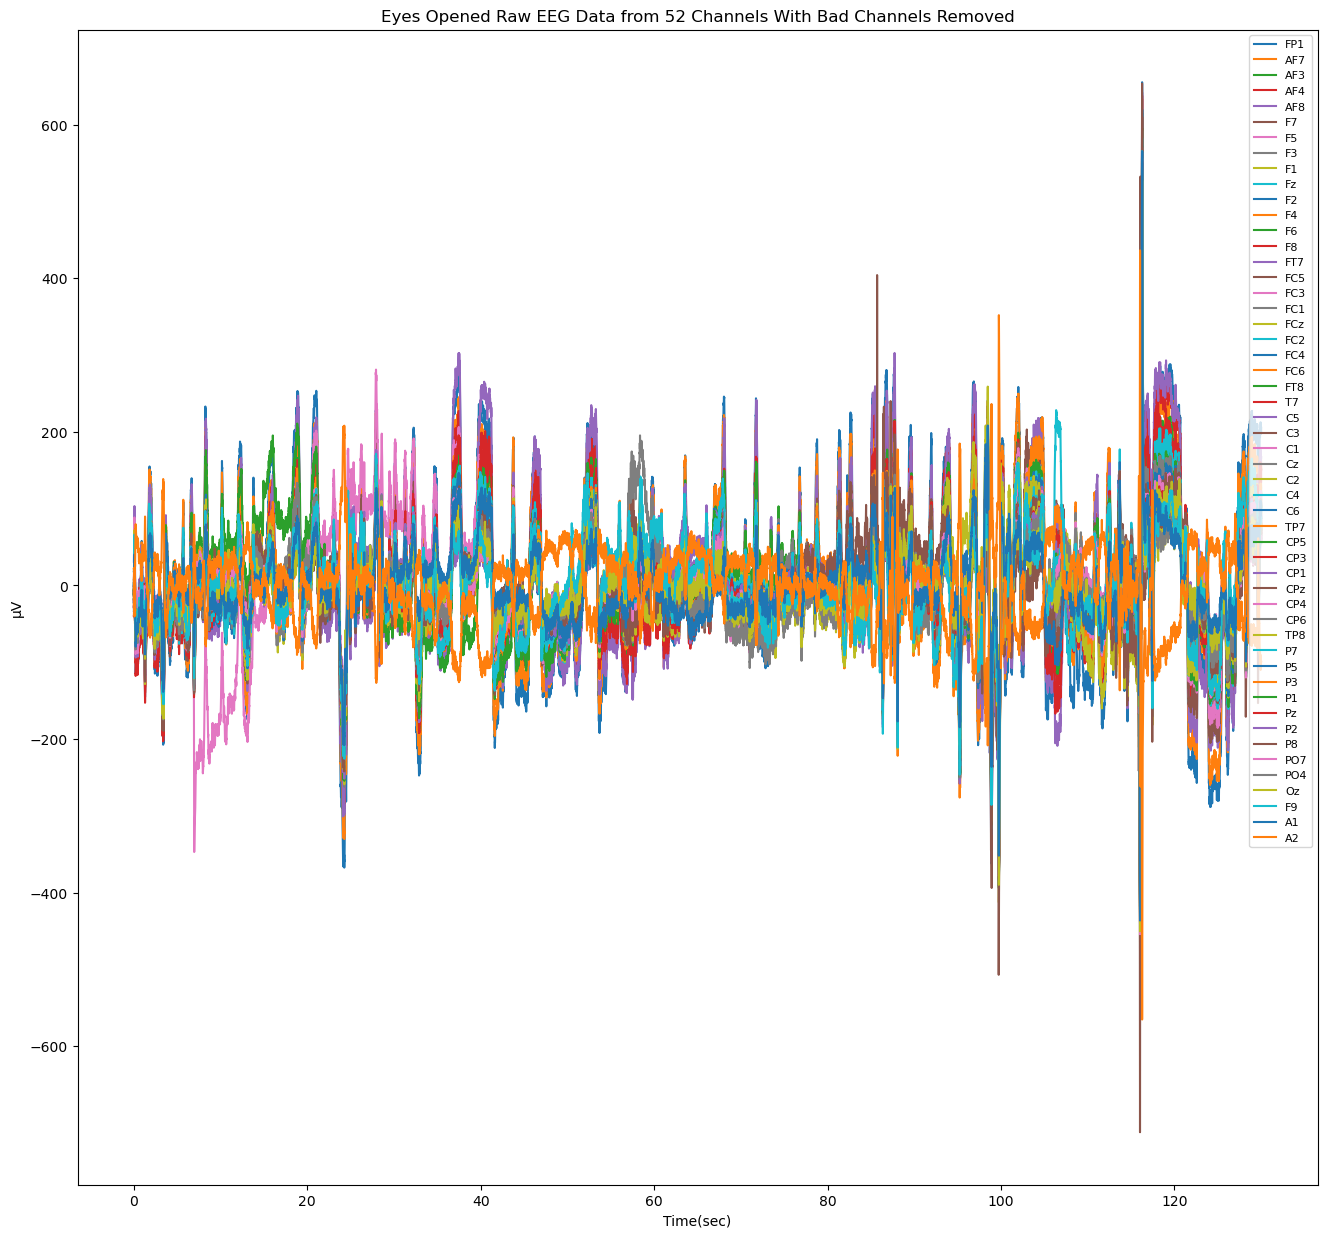

In [12]:
plotMNEData(mne_data=filtered_eo_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Filtered Eyes Opened EEG Data from %d Channels'%(len(filtered_eo_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='filtered_eo_eeg.png', show_plt=True, show_param_ch=False,)
            #channels=['F2', 'Fz', 'F1', 'AF7', 'AF8', 'FPz', 'FP2'])
plotMNEData(mne_data=eo_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Opened Raw EEG Data from %d Channels With Bad Channels Removed'%(len(eo_eeg_wo_bad_ch.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='eo_eeg_wo_bad_ch.png', show_plt=True,show_param_ch=False,)
            #channels=['F2', 'Fz', 'F1', 'AF7', 'AF8', 'FPz', 'FP2'])

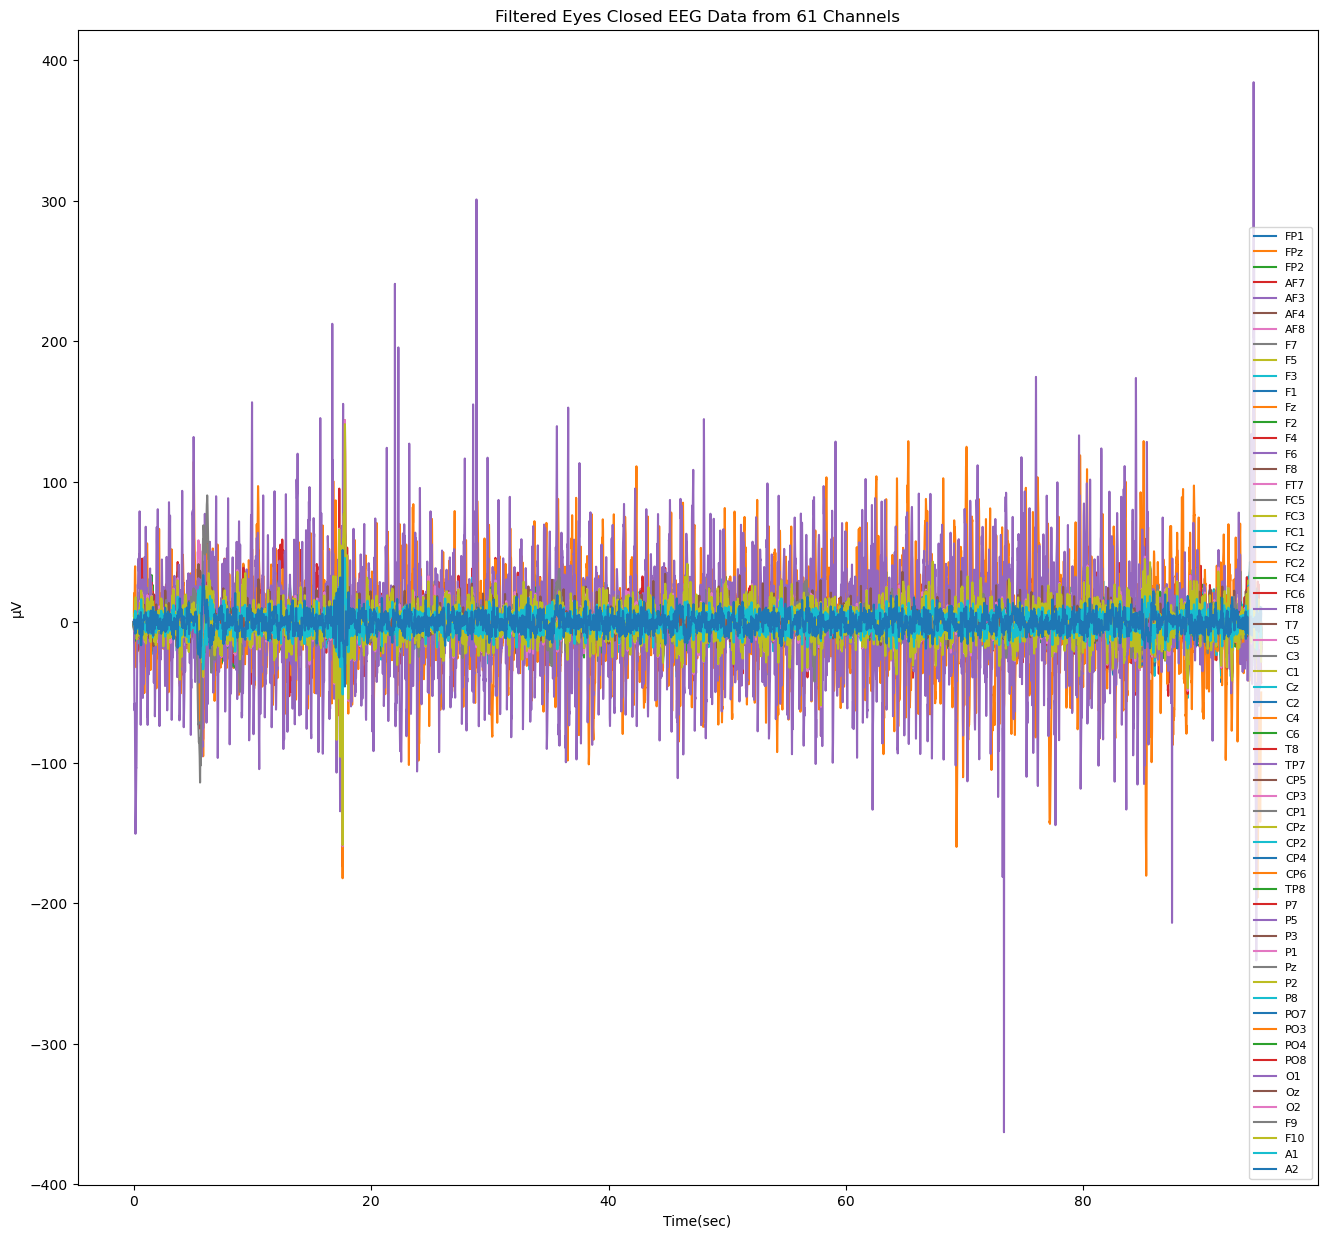

In [13]:
plotMNEData(mne_data=filtered_ec_eeg, domain='time', scaling=1e6, plt_x_range=(0,95),
            title='Filtered Eyes Closed EEG Data from %d Channels'%(len(filtered_ec_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='filtered_ec_eeg.png', show_plt=True, show_param_ch=False,)
            #channels=['Fz'])

In [33]:
#plotMNEData(mne_data=ec_eeg_wo_bad_ch, domain='time', scaling=1e6, plt_x_range=(0,95),
#            title='Eyes Closed Raw EEG Data from %d Channels With Bad Channels Removed'%(len(ec_eeg_wo_bad_ch.ch_names)), 
#            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
#            save_plt_to='ec_eeg_wo_bad_ch.png', show_plt=True,show_param_ch=True,
#            channels=['Fz'])

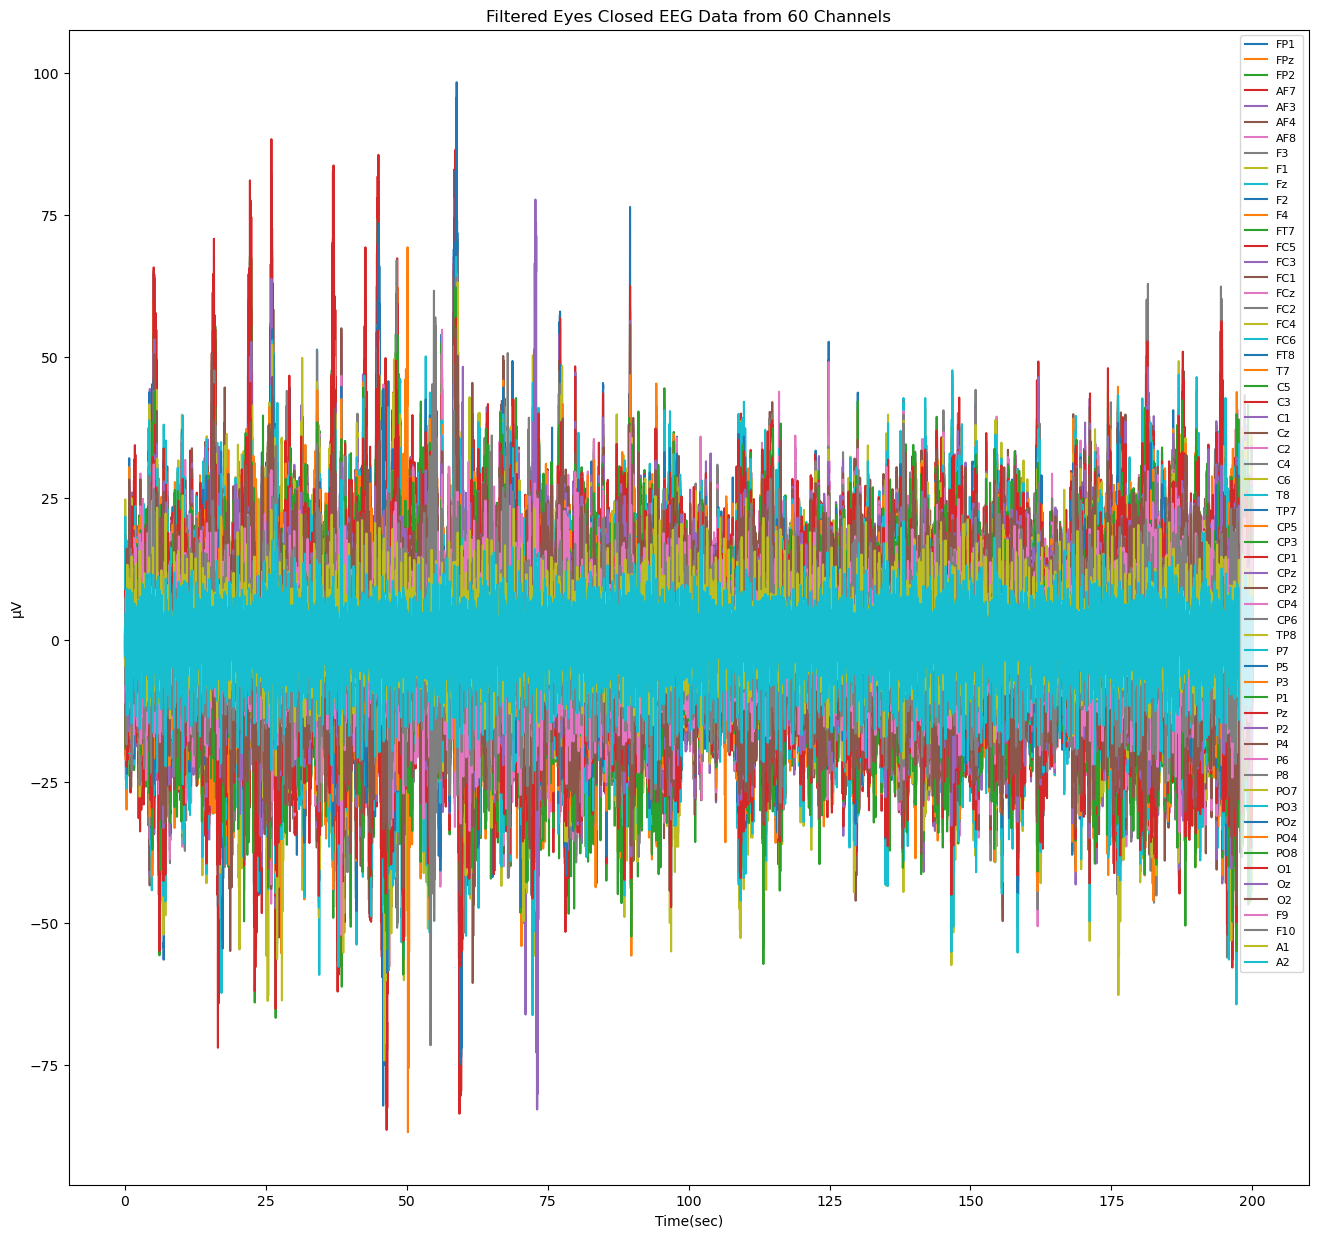

In [47]:
plotMNEData(mne_data=filtered_ec_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Filtered Eyes Closed EEG Data from %d Channels'%(len(filtered_ec_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='filtered_ec_eeg.png', show_plt=True, show_param_ch=False,
            channels=[])

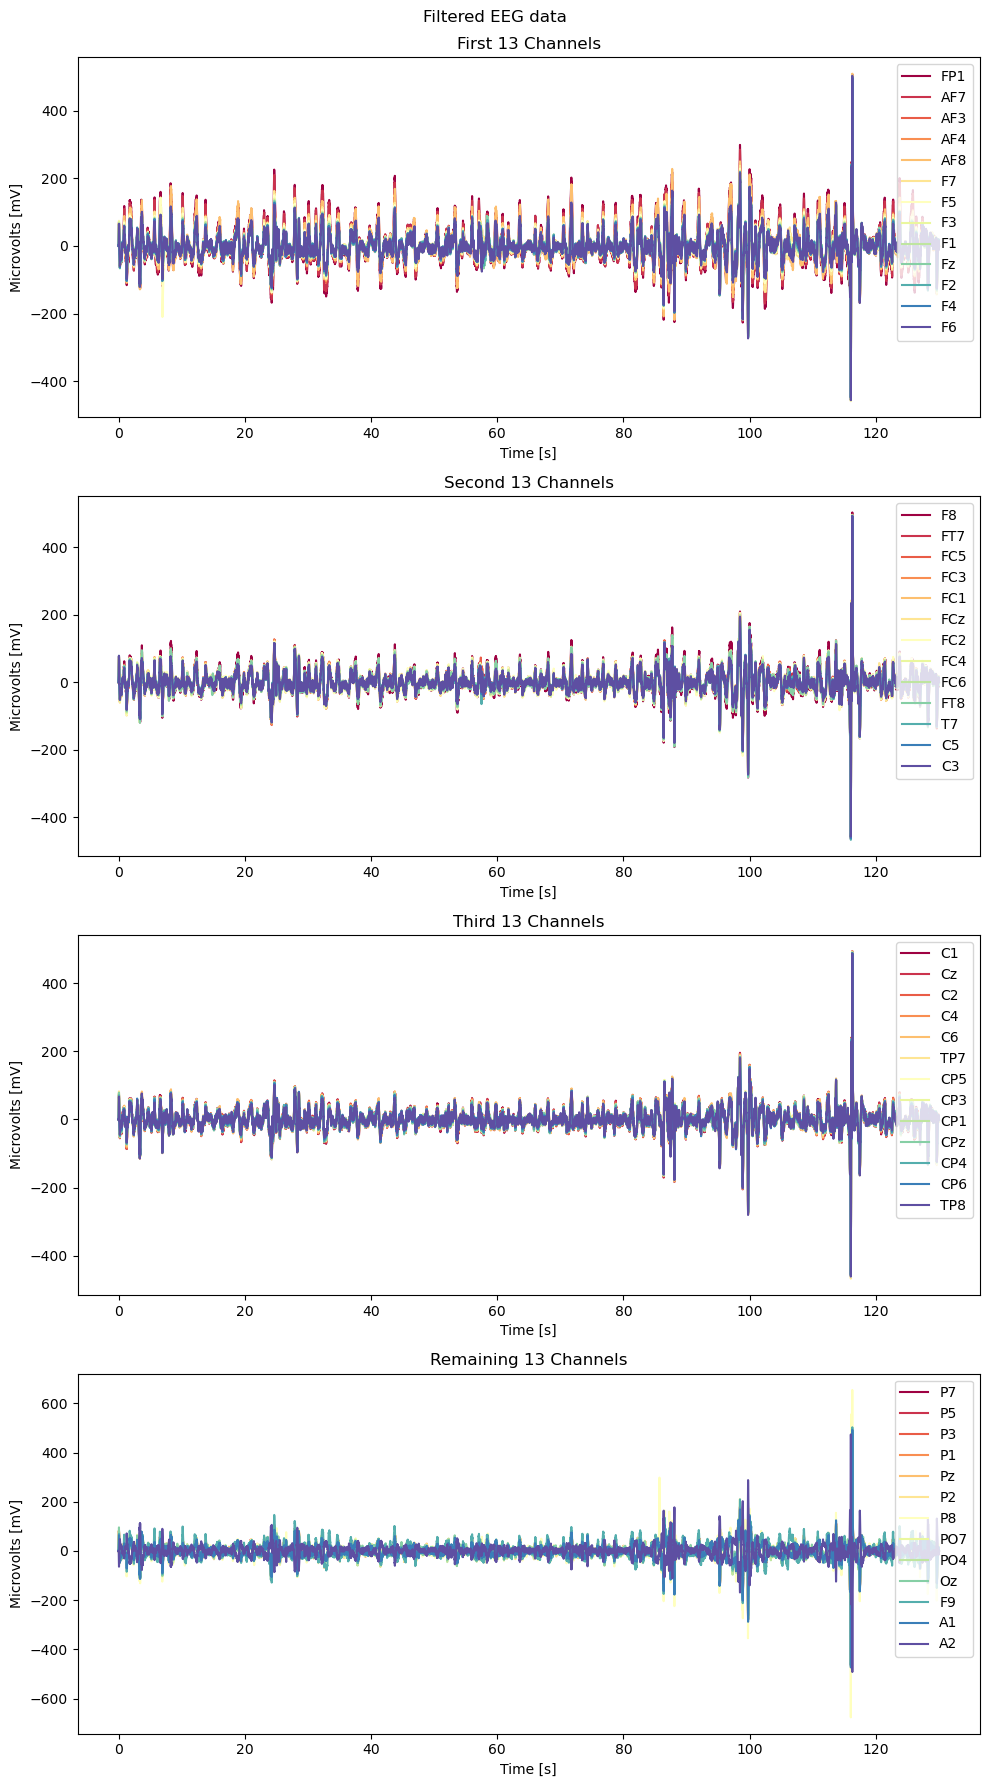

In [15]:
title = 'Filtered EEG data'
plotMNEArrSubplots(filtered_eo_eeg,1e6,title,filtered_eo_eeg.ch_names)

In [16]:
# Create ICA objects for eyes opened/closed data by variance
# Eyes opened
eo_ica = mne.preprocessing.ICA(n_components=0.999, max_iter="auto", random_state=97)
eo_ica.fit(filtered_eo_eeg)

Fitting ICA to data using 52 channels (please be patient, this may take a while)
Selecting by explained variance: 16 components
Fitting ICA took 0.9s.


<ICA | raw data decomposition, method: fastica (fit in 34 iterations on 66564 samples), 16 ICA components (52 PCA components available), channel types: eeg, no sources marked for exclusion>

In [17]:
# Eyes closed
ec_ica = mne.preprocessing.ICA(n_components=0.999, max_iter="auto", random_state=97)
ec_ica.fit(filtered_ec_eeg)

Fitting ICA to data using 61 channels (please be patient, this may take a while)
Selecting by explained variance: 19 components
Fitting ICA took 23.0s.


c:\Users\jimta\mne-python\1.7.0_0\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


<ICA | raw data decomposition, method: fastica (fit in 1000 iterations on 66575 samples), 19 ICA components (61 PCA components available), channel types: eeg, no sources marked for exclusion>

In [27]:
eo_ica.plot_sources(filtered_eo_eeg)

Creating RawArray with float64 data, n_channels=16, n_times=66564
    Range : 0 ... 66563 =      0.000 ...   130.006 secs
Ready.


In [18]:
ec_ica.plot_sources(filtered_ec_eeg)

Creating RawArray with float64 data, n_channels=19, n_times=66575
    Range : 0 ... 66574 =      0.000 ...   130.027 secs
Ready.
Using qt as 2D backend.


In [63]:
# For eye open ryan2024.03.22_15.46.41 with band-pass lowcut 1Hz
eo_comp_to_exclude = [0,4,5,7,10,11,14,1,2,8,15]

# For eye closed ryan2024.03.22_15.26.54 with band-pass lowcut 1Hz
ec_comp_to_exclude = [0,1,2,3,4,7,11,12,15]

# For eye open ryan2024.03.22_15.46.41 with band-pass lowcut 0.3Hz
#eo_comp_to_exclude = [1,6,9,12,13,14,15,0,2,3,5,16]

# For eye closed ryan2024.03.22_15.26.54 with band-pass lowcut 0.3Hz
#ec_comp_to_exclude = [0,2,3,10,11,16,25,2,5,6,9,19,22]

# For eye open2024.04.15_11.11.59 bad channel cutoff ratio 0.03
#eo_comp_to_exclude = [0,1,2,3,9]#,10,12,14,16,23,25,26,27,32,34,36,39,40,42,43,44,46,49,50]

# For eye closed2024.04.15_11.05.18 bad channel cutoff ratio 0.03
#ec_comp_to_exclude = [0,9,12,13]#,14,17,19,20,22,24,26,28,29,31,32,33,34,35,38,40,41,42,45,46,48,49,50,52,53]

# For eye open2024.04.15_11.11.59 bad channel cutoff ratio 0.003
#eo_comp_to_exclude = [0,1,3,4,9,27,31,33,34,35,36,39,40]

# For eye closed2024.04.15_11.05.18 bad channel cutoff ratio 0.003
#ec_comp_to_exclude = [2,6,8,11,14,15,17,18,19,20,21,22,26,27,28,30,31,32,33,35,38,39,41,42,44,45,46]

In [64]:
print(len(eo_comp_to_exclude))
print(len(ec_comp_to_exclude))

11
9


Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 11 ICA components
    Projecting back using 52 PCA components


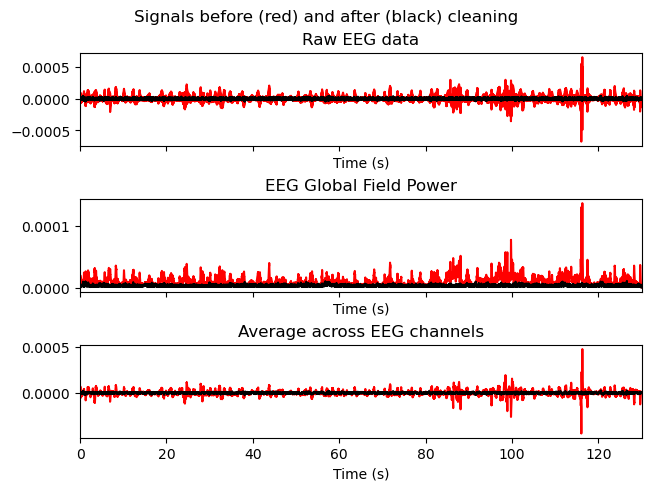

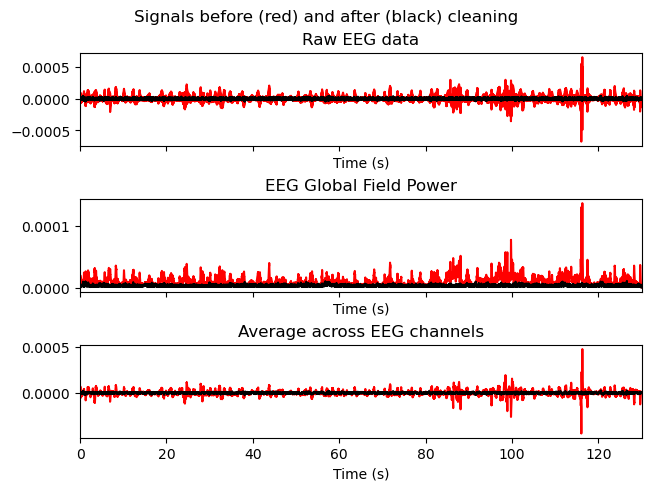

In [65]:
eo_ica.plot_overlay(filtered_eo_eeg, exclude=eo_comp_to_exclude,start=0, stop=102400)

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 9 ICA components
    Projecting back using 61 PCA components


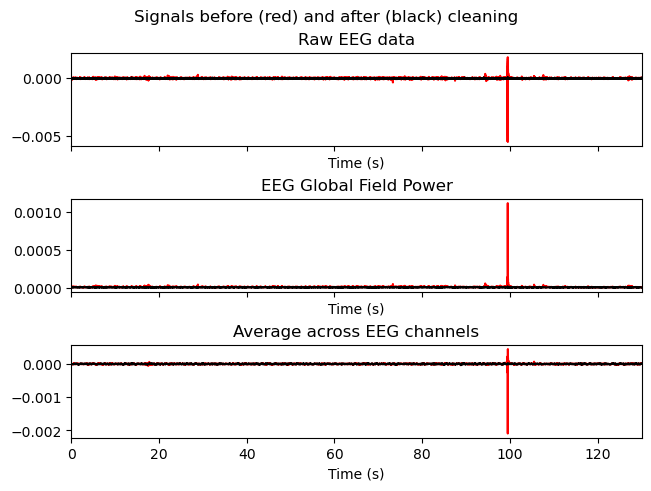

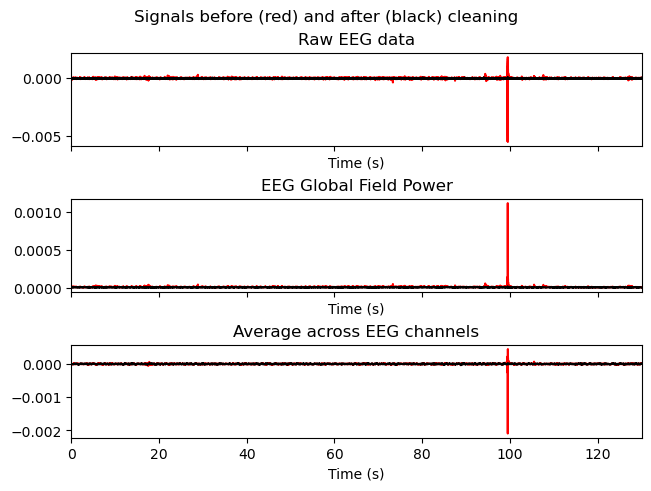

In [66]:
ec_ica.plot_overlay(filtered_ec_eeg, exclude=ec_comp_to_exclude,start=0, stop=102400)

Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 9 ICA components
    Projecting back using 61 PCA components


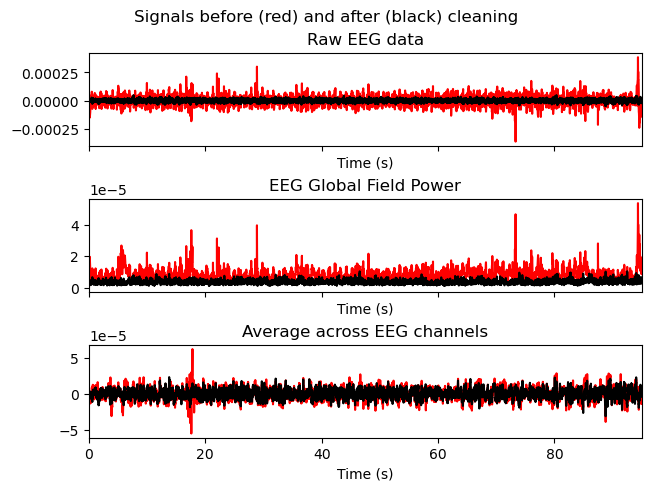

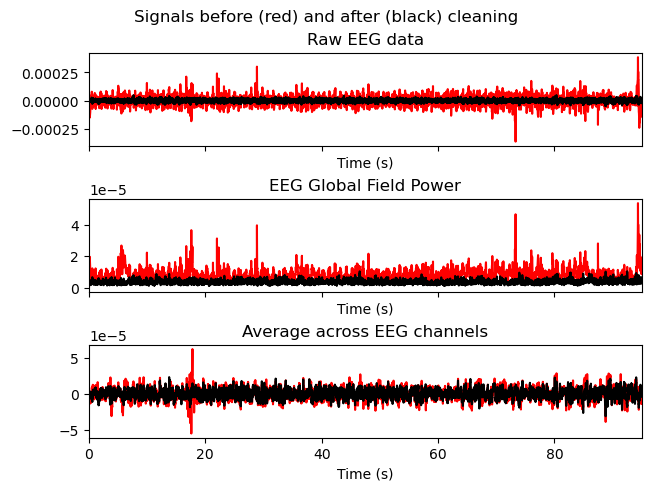

In [67]:
ec_ica.plot_overlay(filtered_ec_eeg, exclude=ec_comp_to_exclude,start=0, stop=48640)

In [68]:
# Set the components to exclude
eo_ica.exclude = eo_comp_to_exclude
ec_ica.exclude = ec_comp_to_exclude

In [69]:
# Actually apply the removal on the filtered data
eo_icaed_eeg = filtered_eo_eeg.copy()
eo_ica.apply(eo_icaed_eeg)

ec_icaed_eeg = filtered_ec_eeg.copy()
ec_ica.apply(ec_icaed_eeg)

Applying ICA to Raw instance
    Transforming to ICA space (16 components)
    Zeroing out 11 ICA components
    Projecting back using 52 PCA components
Applying ICA to Raw instance
    Transforming to ICA space (19 components)
    Zeroing out 9 ICA components
    Projecting back using 61 PCA components


<RawArray | 61 x 66575 (130.0 s), ~31.0 MB, data loaded>

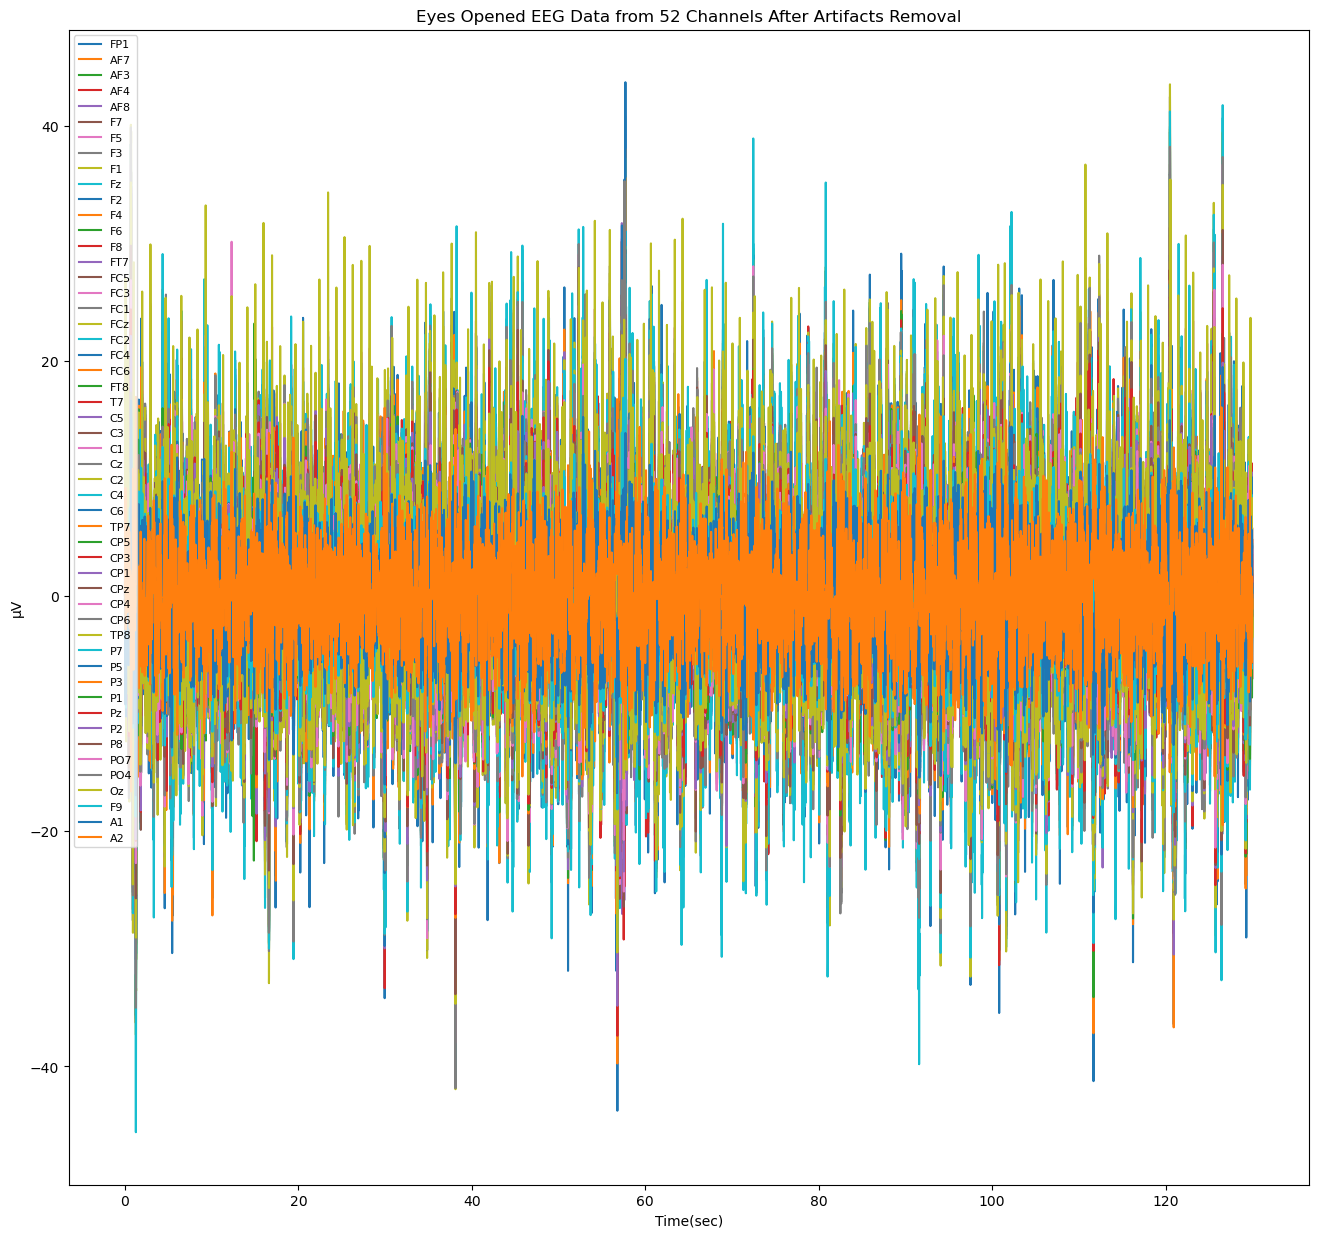

In [70]:
plotMNEData(mne_data=eo_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Opened EEG Data from %d Channels After Artifacts Removal'%(len(eo_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='icaed_eo_eeg.png', show_plt=True)

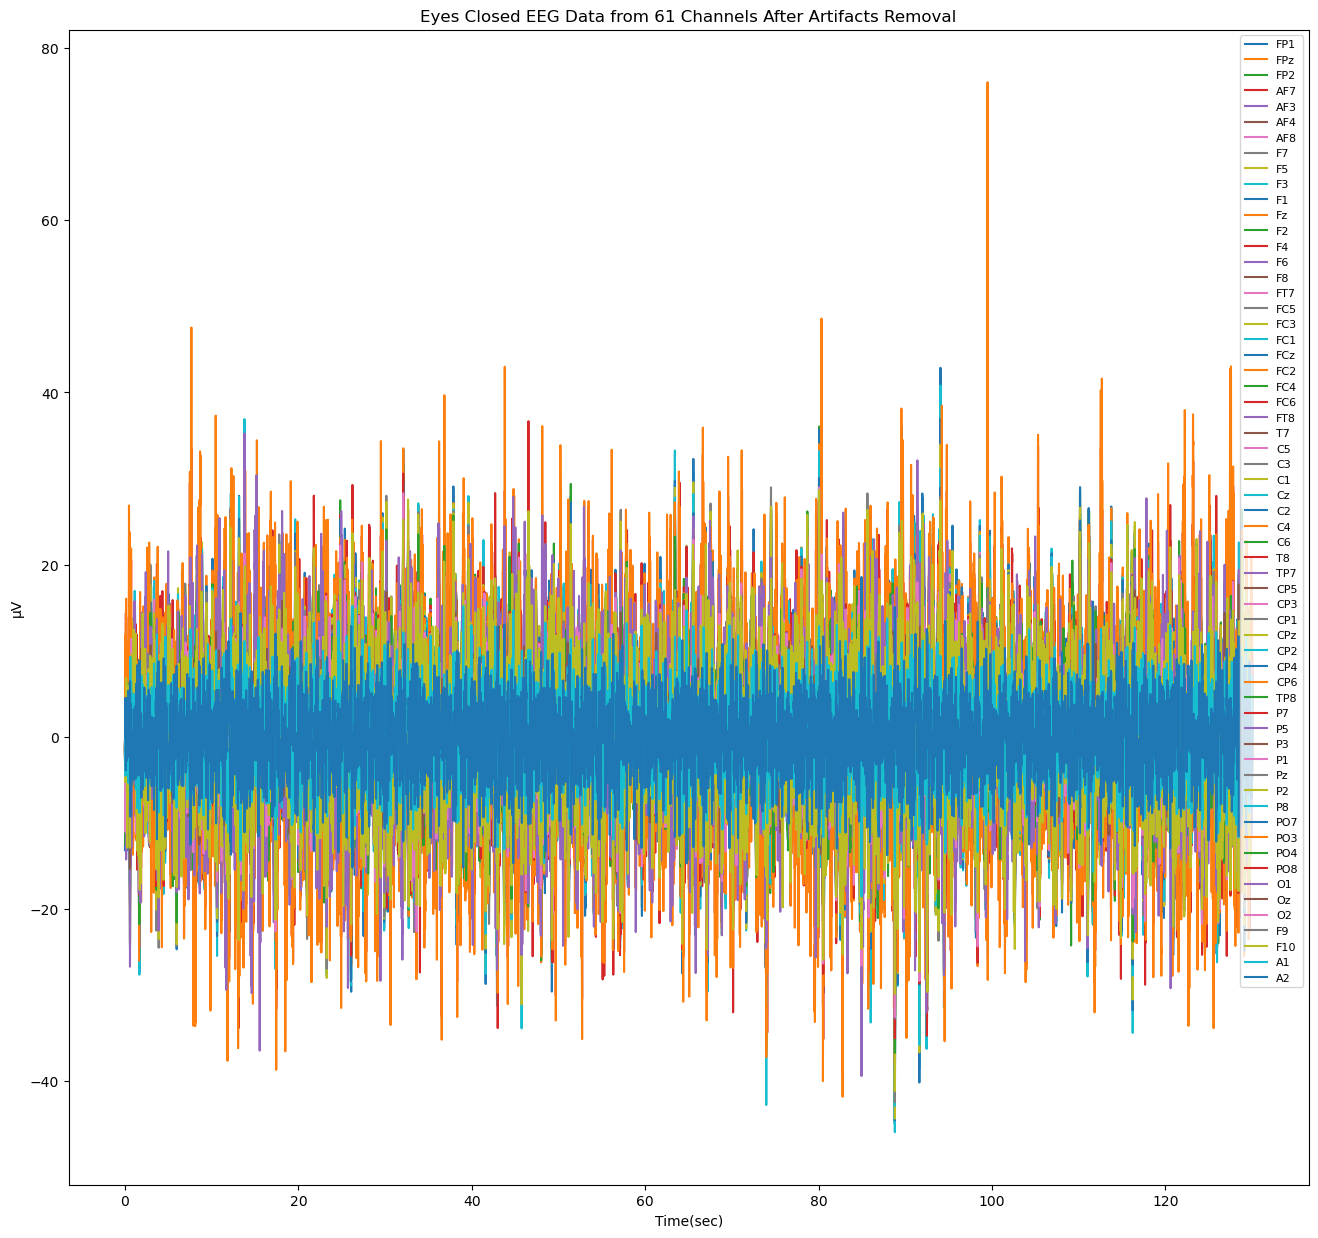

In [26]:
plotMNEData(mne_data=ec_icaed_eeg, domain='time', scaling=1e6, plt_x_range=(0,300),
            title='Eyes Closed EEG Data from %d Channels After Artifacts Removal'%(len(ec_icaed_eeg.ch_names)), 
            x_label="Time(sec)", y_label=u"\u03bcV", plt_method='pyplot',
            save_plt_to='icaed_ec_eeg.png', show_plt=True)

In [71]:
easycap_montage = mne.channels.make_standard_montage('standard_1020')


In [72]:
# Rename eyes opened EEG channel names to match the names in the montage
# For eye open ryan2024.03.22_15.46.41
montage_rename_mapping = {'FP1':'Fp1'}
eo_icaed_eeg.rename_channels(montage_rename_mapping)

# For eye open2024.04.15_11.11.59
#montage_rename_mapping = {'FP1':'Fp1','FPz':'Fpz','FP2':'Fp2'}
#eo_icaed_eeg.rename_channels(montage_rename_mapping)

# For eye open2024.04.15_11.11.59 with bad channel cutoff ratio 0.003
#montage_rename_mapping = {'FPz':'Fpz','FP2':'Fp2'}
#eo_icaed_eeg.rename_channels(montage_rename_mapping)

<RawArray | 52 x 66564 (130.0 s), ~26.5 MB, data loaded>

In [73]:
# Rename eyes closed EEG channel names to match the names in the montage
# For eye closed ryan2024.03.22_15.26.54
montage_rename_mapping = {'FP1':'Fp1','FPz':'Fpz','FP2':'Fp2'}
ec_icaed_eeg.rename_channels(montage_rename_mapping)

# For eye closed2024.04.15_11.05.18
#montage_rename_mapping = {'FP1':'Fp1','FPz':'Fpz','FP2':'Fp2'}
#ec_icaed_eeg.rename_channels(montage_rename_mapping)

# For eye closed2024.04.15_11.05.18 with bad channel cutoff ratio 0.003
#montage_rename_mapping = {'FPz':'Fpz','FP2':'Fp2'}
#ec_icaed_eeg.rename_channels(montage_rename_mapping)

<RawArray | 61 x 66575 (130.0 s), ~31.0 MB, data loaded>

In [74]:
# Setup montage for EEG data
eo_icaed_eeg.set_montage(easycap_montage)
ec_icaed_eeg.set_montage(easycap_montage)

<RawArray | 61 x 66575 (130.0 s), ~31.1 MB, data loaded>

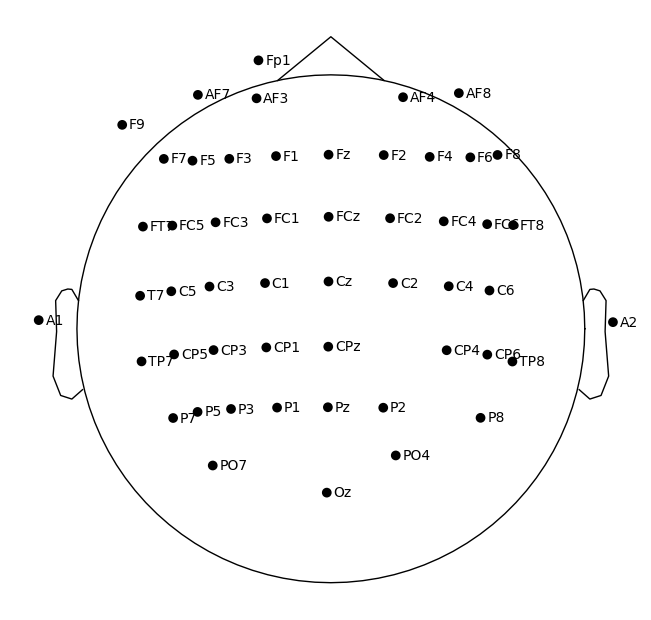

In [56]:
fig = eo_icaed_eeg.plot_sensors(show_names=True)

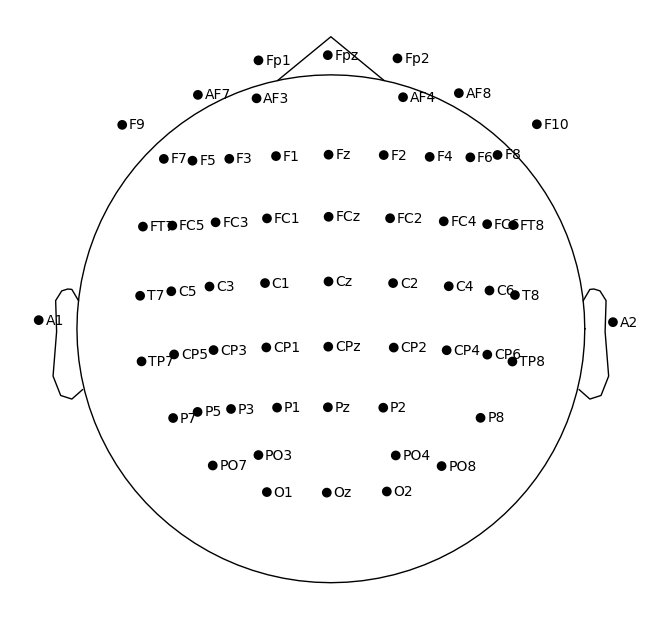

In [57]:
fig = ec_icaed_eeg.plot_sensors(show_names=True)

In [75]:
# There are two spectral estimation methods, Welch and Multitaper (uses DPSS tapers)
# Change n_fft for welch method to change the number of bins in each unit of frequency 
# n*icaed_eeg.info["sfreq"] -> n equal-width bins in each frequency
# Compute PSD for eyes opened data
eo_welch_psd = eo_icaed_eeg.compute_psd(method='welch',n_fft=int(20*eo_icaed_eeg.info["sfreq"]), fmin=0,fmax=30)
# Compute PSD for eyes closed data
ec_welch_psd = ec_icaed_eeg.compute_psd(method='welch',n_fft=int(20*ec_icaed_eeg.info["sfreq"]), fmin=0,fmax=30)

Effective window size : 20.000 (s)
Effective window size : 20.000 (s)


In [76]:
plotMNEData(mne_data=eo_welch_psd, domain='freq', scaling=1e12, plt_x_range=(0,4),
            title='Delta Band Eyes Opened EEG PSD from %d Channels'%(len(eo_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='eo_eeg_delta_psd.html', show_plt=True)
plotMNEData(mne_data=ec_welch_psd, domain='freq', scaling=1e12, plt_x_range=(0,4),
            title='Delta Band Eyes Closed EEG PSD from %d Channels'%(len(ec_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='ec_eeg_delta_psd.html', show_plt=True)

In [77]:
plotMNEData(mne_data=eo_welch_psd, domain='freq', scaling=1e12, plt_x_range=(4,8),
            title='Theta Band Eyes Opened EEG PSD from %d Channels'%(len(eo_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='eo_eeg_theta_psd.html', show_plt=True)
plotMNEData(mne_data=ec_welch_psd, domain='freq', scaling=1e12, plt_x_range=(4,8),
            title='Theta Band Eyes Closed EEG PSD from %d Channels'%(len(ec_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='ec_eeg_theta_psd.html', show_plt=True)

In [78]:
plotMNEData(mne_data=eo_welch_psd, domain='freq', scaling=1e12, plt_x_range=(8,12),
            title='Alpha Band Eyes Opened EEG PSD from %d Channels'%(len(eo_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='eo_eeg_alpha_psd.html', show_plt=True, show_param_ch=False,)
            #channels=['Fp1','Fpz','Fp2','AF7', 'AF3'])
plotMNEData(mne_data=ec_welch_psd, domain='freq', scaling=1e12, plt_x_range=(8,12),
            title='Alpha Band Eyes Closed EEG PSD from %d Channels'%(len(ec_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='ec_eeg_alpha_psd.html', show_plt=True, show_param_ch=False,)
            #channels=['Fp1','Fpz','Fp2','AF7', 'AF3'])

In [79]:
plotMNEData(mne_data=eo_welch_psd, domain='freq', scaling=1e12, plt_x_range=(12,30),
            title='Beta Band Eyes Opened EEG PSD from %d Channels'%(len(eo_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='eo_eeg_beta_psd.html', show_plt=True)
plotMNEData(mne_data=ec_welch_psd, domain='freq', scaling=1e12, plt_x_range=(12,30),
            title='Beta Band Eyes Closed EEG PSD from %d Channels'%(len(ec_welch_psd.ch_names)), 
            x_label="Frequency(Hz)", y_label=u"\u03bcV<sup>2</sup>/Hz", plt_method='plotly',
            save_plt_to='ec_eeg_beta_psd.html', show_plt=True)

In [80]:
FREQ_BANDS_DICT = {'Delta (0-4 Hz)': (0.5, 4), 'Theta (4-8 Hz)': (4, 8),
                   'Alpha (8-12 Hz)': (8, 12), 'Beta (12-30 Hz)': (12, 30)}

def plotPSDTopomap(psd_data, ch_to_exclude:list=[]):
    psd_wo_exclude_ch = psd_data.copy().drop_channels(ch_to_exclude)
    psd_wo_exclude_ch.plot_topomap(bands = FREQ_BANDS_DICT,cmap = 'Reds')


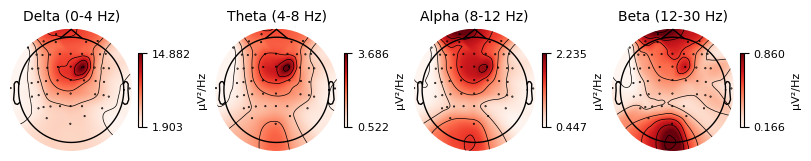

In [81]:
# PSD topomap for Eyes Opened Data
plotPSDTopomap(eo_welch_psd)

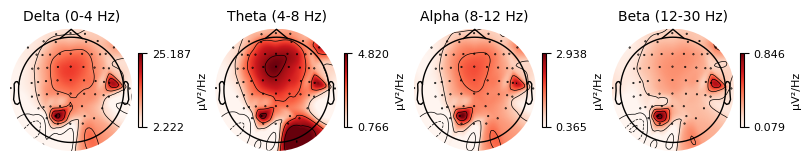

In [88]:
# PSD topomap for Eyes Closed Data
plotPSDTopomap(ec_welch_psd,)

In [83]:
def computeAvgBandPower(psd,band_range):
    psd_df = psd.to_data_frame(copy=True)
    # Scaling with 1e12 to micro-volt^2/Hz
    for col in psd_df.drop(['freq'],axis=1):
        psd_df[col] = psd_df[col]*1e12

    band_low,band_high = band_range
    psd_in_selected_band = psd_df[(psd_df['freq']>=band_low) & (psd_df['freq']<band_high)]
    average_band_power = psd_in_selected_band.drop(['freq'], axis=1).mean()
    return average_band_power

In [84]:
def computeRelativeBandPower(psd,tuples_of_bands):
    psd_df = psd.to_data_frame(copy=True)
    # Scaling with 1e12 to micro-volt^2/Hz
    for col in psd_df.drop(['freq'],axis=1):
        psd_df[col] = psd_df[col]*1e12

    band_sum = 0
    list_of_bands = []
    for band_tuple in tuples_of_bands:
        band_low,band_high = band_tuple
        psd_in_selected_band = psd_df[(psd_df['freq']>=band_low) & (psd_df['freq']<band_high)]
        sum_of_band = psd_in_selected_band.iloc[:,1:].sum()
        list_of_bands.append(sum_of_band)
        band_sum+= sum_of_band
    return list_of_bands,band_sum

In [85]:
# Define frequency bands
FREQ_BANDS = {'Delta': (0.5, 4),
              'Theta': (4, 8),
              'Alpha': (8, 12),
              'Beta': (13, 30)
            }

def computeSaveAllAvgBandPowers(eeg_psds:list, conditions:list):
    # Initialize a dictionary to record the power averages
    power_avgs = {condition: {band: [] for band in FREQ_BANDS} for condition in conditions}

    # Process each condition
    for condition, psd in zip(conditions, eeg_psds):
        # Calculate the mean power for each band
        for band, (freq_min, freq_max) in FREQ_BANDS.items():
            power_avgs[condition][band] = computeAvgBandPower(psd, (freq_min, freq_max))
    # Save average band powers in csv
    for condition, bands_data in power_avgs.items():
        df = pd.DataFrame(bands_data)
        df.to_csv(f'{condition}_band_powers.csv', index_label='Channel')

In [86]:
computeSaveAllAvgBandPowers([ec_welch_psd,eo_welch_psd],['ec','eo'])

In [83]:
#computeAvgBandPower(ec_welch_psd,(0.5,4)).plot(kind = "bar")